# Modelling Building Efficiency in NY

Data: BlocPower and Public Heating and Cooling data from 103 New York Buildings

## 1. Import Python Libraries & Load Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model

In [3]:
bloc_df = pd.read_csv('BlocPower_T.csv')
cdd_hdd_df = pd.read_csv('CDD-HDD-Features.csv')
hdd_df = pd.read_csv('HDD-Features.csv')
energy_loc_df = pd.read_csv('clusterEnergyLocation.csv')
sensor_data_df = pd.read_csv('CombinedSensorData.csv')
energy_loc_df = energy_loc_df[['AddressID', 'property_name', 'Address', 'Zipcode', 'Long', 'Lat', 'Annual Energy Bill (USD)']]

In [4]:
#Buidling information provided by BlocPower
bloc_df.head(1)

,UTSUM_Electricity_Usage,INFO_Year of Construction,INFO_Number of Stories,INFO_Total Square Feet,PLEI_1_Quantity,PLEI_3_Quantity
0,"117,870 kWh",1955,4,"14,600",1.0,2


In [5]:
#Buidling information provided by BlocPower
energy_loc_df.head(1)

,AddressID,property_name,Address,Zipcode,Long,Lat,Annual Energy Bill (USD)
0,125 East 105th Street10029,ChurchofStCeciliaReport,125 East 105th Street,10029,-73.947326,40.791919,"$21,216.60"


In [6]:
#Public buidling energy data 
cdd_hdd_df.head(1)

,Property Name,plug_load_consumption,ac_consumption,domestic_gas,heating_gas
0,ChurchofStCeciliaReport,11.651406,0.983531,0.096226,0.366193


## 2. Data Preparation

#### BlocPower_T.csv Transformation to df

In [7]:
#display info
bloc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 6 columns):
UTSUM_Electricity_Usage      98 non-null object
INFO_Year of Construction    100 non-null object
INFO_Number of Stories       103 non-null int64
INFO_Total Square Feet       103 non-null object
PLEI_1_Quantity              95 non-null float64
PLEI_3_Quantity              88 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 4.9+ KB


In [8]:
# column 'UTSUM_Electricity_Usage' is an object type with NaN values. 

#Removes unwanted characters
bloc_df['UTSUM_Electricity_Usage'] = bloc_df['UTSUM_Electricity_Usage'].map(lambda x: str(x)[:-4])
bloc_df['UTSUM_Electricity_Usage'].replace(regex=True,inplace=True,to_replace=r',',value=r'')

#Converts column to float type
UT = []
for i in bloc_df['UTSUM_Electricity_Usage']:
    try:
        UT.append(np.float(i))
    except:
        UT.append(np.nan)
bloc_df['UTSUM_Electricity_Usage'] = UT

#fills NaNs with mean values
mean_usage = bloc_df['UTSUM_Electricity_Usage'].mean()
bloc_df['UTSUM_Electricity_Usage'].fillna(mean_usage, inplace=True)

In [9]:
# column 'INFO_Year of Construction' is an object type with NaN values. 

#Converts column to float type
year = []
for i in bloc_df['INFO_Year of Construction']:
    try:
        year.append(np.float(i))
    except:
        year.append(np.nan)
bloc_df['INFO_Year of Construction'] = year

#Calculates Age of building
age = []
for i in bloc_df['INFO_Year of Construction']:
    try:
        age.append(2016.0-i)
    except:
        age.append(np.nan)
bloc_df['Age'] = age

#fills NaNs with mean values
mean_age = bloc_df['Age'].mean()
bloc_df['Age'].fillna(mean_age, inplace=True)

In [10]:
# column 'INFO_Total Square Feet' is an object. 

#Removes unwanted characters
bloc_df['INFO_Total Square Feet'].replace(regex=True,inplace=True,to_replace=r',',value=r'')

#Converts column to float type
sf = []
for i in bloc_df['INFO_Total Square Feet']:
    try:
        sf.append(np.float(i))
    except:
        sf.append(np.nan)
bloc_df['INFO_Total Square Feet'] = sf

In [11]:
# column 'PLEI_1_Quantity' has NaN values, interpreted as 0 plugged in electrical equipments

#fill NaNs with zeros
bloc_df['PLEI_1_Quantity'].fillna(0, inplace=True)

In [12]:
# column 'PLEI_3_Quantity' is an object type with NaN values, interpreted as 0 plugged in electrical equipments

#Converts column to float type
plei = []
for i in bloc_df['PLEI_3_Quantity']:
    try:
        plei.append(np.float(i))
    except:
        plei.append(np.nan)
bloc_df['PLEI_3_Quantity'] = plei
        
#fill NaNs with zeros
bloc_df['PLEI_3_Quantity'].fillna(0, inplace=True)

#### clusterEnergyLocation.csv Transformation to df

In [13]:
#display info
energy_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 7 columns):
AddressID                   103 non-null object
property_name               103 non-null object
Address                     103 non-null object
Zipcode                     103 non-null int64
Long                        103 non-null float64
Lat                         103 non-null float64
Annual Energy Bill (USD)    103 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 5.7+ KB


In [14]:
# column 'Annual Energy Bill (USD)' is an object type. 

#Removes unwanted characters
energy_loc_df['Annual Energy Bill (USD)'].replace(regex=True,inplace=True,to_replace=r'\$',value=r'')
energy_loc_df['Annual Energy Bill (USD)'].replace(regex=True,inplace=True,to_replace=r',',value=r'')

#Converts column to float type
usd = []
for i in energy_loc_df['Annual Energy Bill (USD)']:
    try:
        usd.append(np.float(i))
    except:
        usd.append(np.nan)
energy_loc_df['Annual Energy Bill (USD)'] = usd

#### CDD-HDD-Features.csv Transformation to df

In [15]:
cdd_hdd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 5 columns):
Property Name            103 non-null object
plug_load_consumption    103 non-null float64
ac_consumption           103 non-null float64
domestic_gas             103 non-null float64
heating_gas              103 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.1+ KB


#### Bring all Together

In [16]:
#concatenate with cdd_hdd_df to include domestic gas and heating gas
bloc_df= pd.concat([cdd_hdd_df, bloc_df], axis=1)
bloc_df= pd.concat([bloc_df, energy_loc_df], axis =1)

#Rename Columns
bloc_df.columns = ['Property Name', 'Plug Load Consumption', 'AC Consumption','Domestic Gas', 'Heating Gas','Energy Usage', 'Year of Construction', 'Number of Stories', 'Square Feet', 'PLEI_1', 'PLEI_3', 'Age', 'Address ID', 'property_name', 'Address', 'Zipcode', 'Longitude', 'Latitude', 'Annual Energy Bill (USD)' ]
bloc_df = bloc_df[['Property Name', 'Energy Usage', 'Age', 'Number of Stories', 'Square Feet', 'PLEI_1', 'PLEI_3', 'Domestic Gas', 'Heating Gas', 'Plug Load Consumption', 'AC Consumption', 'Annual Energy Bill (USD)', 'Year of Construction', 'Address ID', 'Address', 'Zipcode', 'Longitude', 'Latitude']]

In [17]:
bloc_df.head(1)

,Property Name,Energy Usage,Age,Number of Stories,Square Feet,PLEI_1,PLEI_3,Domestic Gas,Heating Gas,Plug Load Consumption,AC Consumption,Annual Energy Bill (USD),Year of Construction,Address ID,Address,Zipcode,Longitude,Latitude
0,ChurchofStCeciliaReport,117870.0,61.0,4,14600.0,1.0,2.0,0.096226,0.366193,11.651406,0.983531,21216.6,1955.0,125 East 105th Street10029,125 East 105th Street,10029,-73.947326,40.791919


In [18]:
#display info after data cleaned
bloc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 18 columns):
Property Name               103 non-null object
Energy Usage                103 non-null float64
Age                         103 non-null float64
Number of Stories           103 non-null int64
Square Feet                 103 non-null float64
PLEI_1                      103 non-null float64
PLEI_3                      103 non-null float64
Domestic Gas                103 non-null float64
Heating Gas                 103 non-null float64
Plug Load Consumption       103 non-null float64
AC Consumption              103 non-null float64
Annual Energy Bill (USD)    103 non-null float64
Year of Construction        96 non-null float64
Address ID                  103 non-null object
Address                     103 non-null object
Zipcode                     103 non-null int64
Longitude                   103 non-null float64
Latitude                    103 non-null float64
dtypes: float64(13), 

## 3. Exploratory Analysis

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


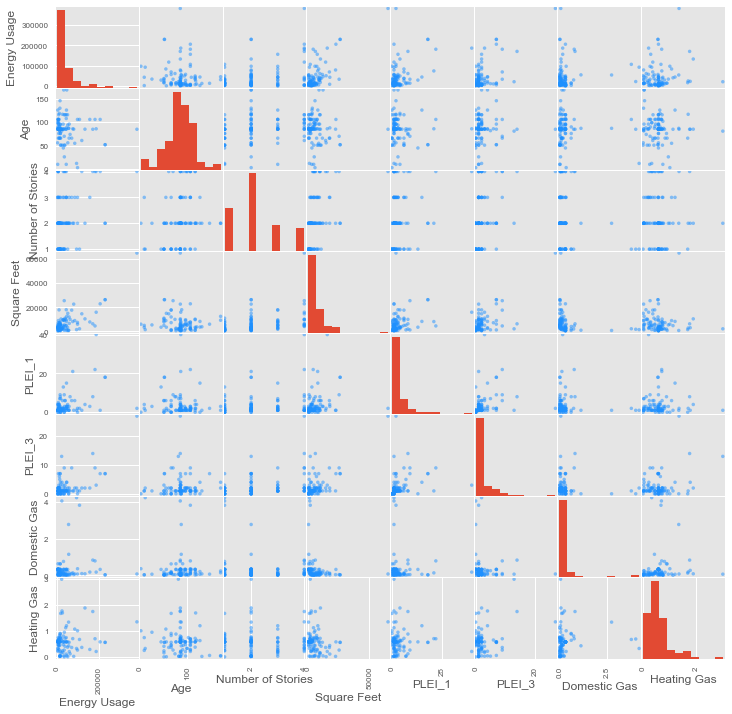

In [19]:
#Show correlation matrix
plt.style.use('ggplot')
correlations = pd.tools.plotting.scatter_matrix(bloc_df[['Property Name', 'Energy Usage', 'Age', 
                                                         'Number of Stories', 'Square Feet', 'PLEI_1', 
                                                         'PLEI_3', 'Domestic Gas', 'Heating Gas']], 
                                                diagonal='hist',figsize=(12,12), color='#1e90ff')

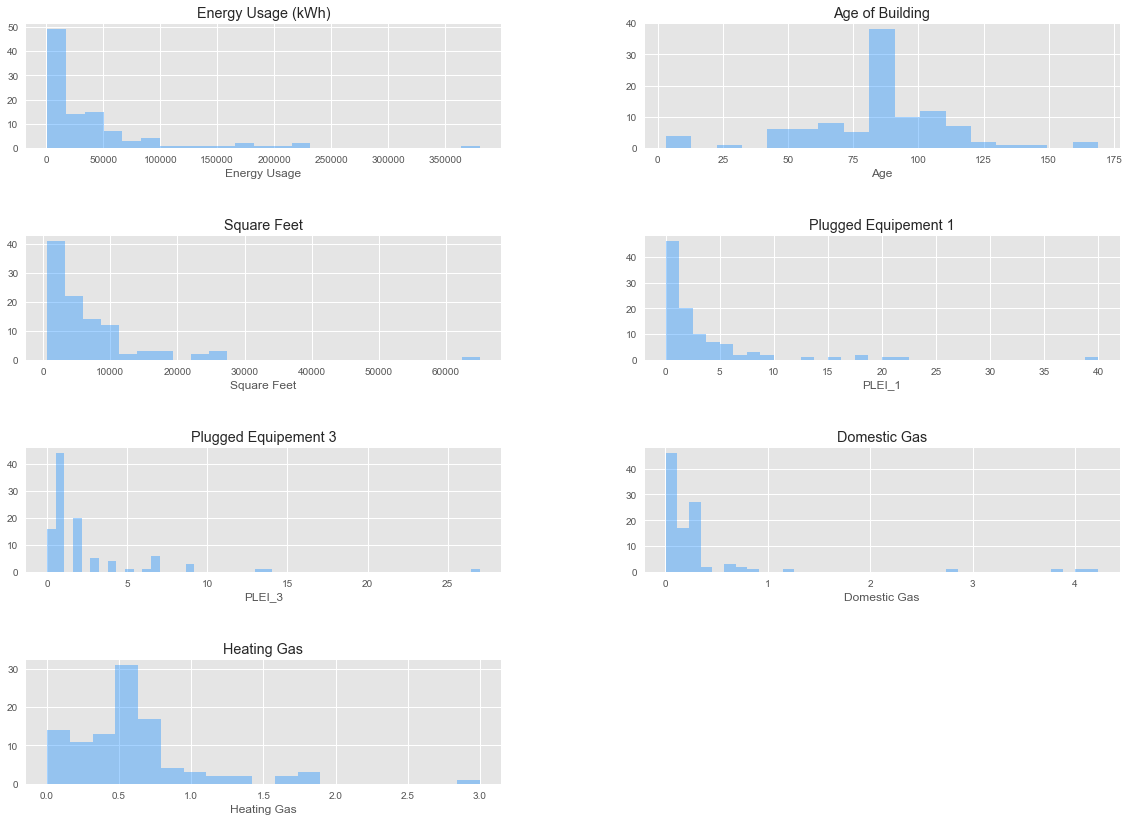

In [20]:
#Plot Histograms of Parameters

a =plt.subplot(421)
sns.distplot(bloc_df["Energy Usage"], color='#1e90ff', kde=False)
a.set_title("Energy Usage (kWh)")

b =plt.subplot(422)
sns.distplot(bloc_df['Age'], color='#1e90ff', kde=False)
b.set_title("Age of Building")

c =plt.subplot(423)
sns.distplot(bloc_df['Square Feet'], color='#1e90ff', kde=False)
c.set_title("Square Feet")

d =plt.subplot(424)
sns.distplot(bloc_df['PLEI_1'], color='#1e90ff', kde=False)
d.set_title("Plugged Equipement 1")

e =plt.subplot(425)
sns.distplot(bloc_df['PLEI_3'], color='#1e90ff', kde=False)
e.set_title("Plugged Equipement 3")

f =plt.subplot(426)
sns.distplot(bloc_df['Domestic Gas'], color='#1e90ff', kde=False)
f.set_title("Domestic Gas")

g =plt.subplot(427)
sns.distplot(bloc_df['Heating Gas'], color='#1e90ff', kde=False)
g.set_title("Heating Gas")

plt.subplots_adjust(top=2, bottom=0.08, left=0.10, right=2, hspace=.7, wspace=0.3)
plt.show()

## 4. Regression Analysis

In [21]:
from sklearn import preprocessing
regr_df = bloc_df[['Energy Usage', 'Age', 'Number of Stories', 'Square Feet', 'PLEI_1', 'PLEI_3', 'Domestic Gas', 'Heating Gas']]
scaler = preprocessing.MaxAbsScaler() 
feat = scaler.fit_transform(regr_df)
cols = regr_df.columns

# define a new dataframe with the scaled data
dfScaled = pd.DataFrame(feat,columns=cols)

# get a list of the features used to explain energy
features = dfScaled.columns.tolist()
features.remove('Energy Usage')

# declare a linear regression model 
lr = linear_model.LinearRegression(fit_intercept=True)

# define independent variable
y = np.array(dfScaled['Energy Usage']) 

# define features
x = dfScaled[features]

# fit regression model to the data
regression = lr.fit(x,y)
coefficient = regression.coef_

# collect regression coefficients
dataRegQ = []
dataRegQ.append(('Intercept', regression.intercept_))
for i in range(len(features)):
    dataRegQ.append((features[i],coefficient[i]))

# compute energy predictions using our fitted model     
yh = regression.predict(x)

# import package to compute the R-squared quality metric
from sklearn.metrics import r2_score
# print results
print ('R-Squared: ', r2_score(y,yh))
pd.DataFrame(dataRegQ,columns=['feature_name','coefficient'])

R-Squared:  0.71750454564


,feature_name,coefficient
0,Intercept,-0.067143
1,Age,-0.023500
2,Number of Stories,0.048774
3,Square Feet,0.777122
4,PLEI_1,0.312308
5,PLEI_3,0.122954
6,Domestic Gas,0.229171
7,Heating Gas,0.143661


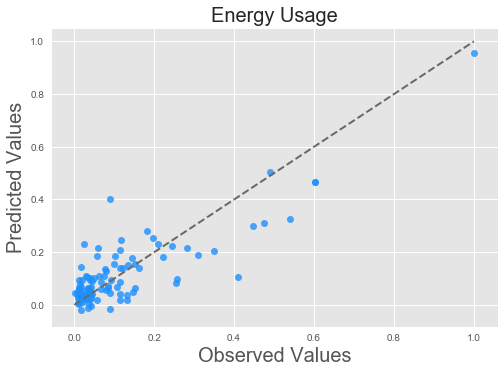

In [22]:
#Plot dashed line to represent perfect model
x1=[0,1]
y1=[0,1]
plt.plot(x1, y1, linewidth=2.0, linestyle='dashed', color='#696969')

#plot observed vs. predicted values
sns.regplot(y,yh, fit_reg=False, color = '#1e90ff')
plt.xlabel('Observed Values', fontsize=20)
plt.ylabel('Predicted Values', fontsize=20)
plt.title('Energy Usage', fontsize=20)

## 5. Labelling Inefficient Buildings

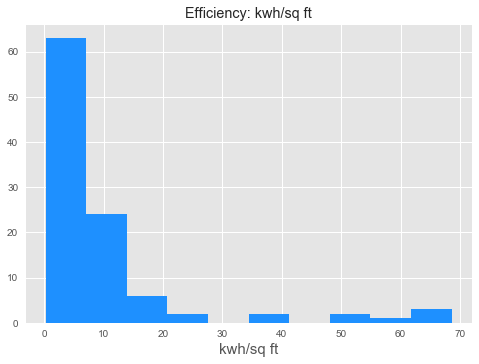

In [23]:
#calculate kwh/sq ft and add to data frame
bloc_df['kwh/sq ft'] = bloc_df['Energy Usage']/bloc_df['Square Feet']

#plot histogram of kwh/sq ft
plt.hist(bloc_df['kwh/sq ft'], color = '#1e90ff')
plt.title('Efficiency: kwh/sq ft')
plt.xlabel('kwh/sq ft', fontsize=15)

In [24]:
#Buildings with kwh/sq ft>20 will be lables as Inefficient with a True value
bloc_df['Inefficient'] = bloc_df['kwh/sq ft']>20

## 6. Modelling: Unsupervised Learning

#### Kmeans using all parameters

In [25]:
#Using all parameters
kmeans_df1 = bloc_df.copy(deep=True)
del kmeans_df1['Inefficient']
del kmeans_df1['Property Name']
del kmeans_df1['Year of Construction']
del kmeans_df1['Address ID']
del kmeans_df1['Address']
del kmeans_df1['Zipcode']
del kmeans_df1['Longitude']
del kmeans_df1['Latitude']
del kmeans_df1['kwh/sq ft']

k = 2


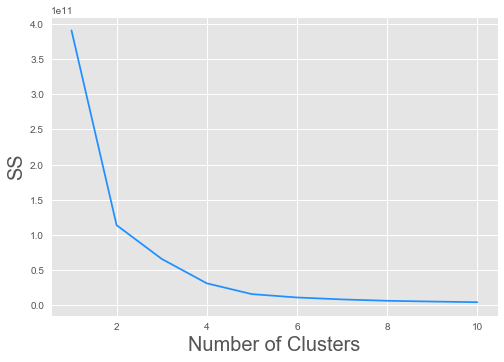

In [26]:
#Choosing K-clusters: elbow method
import scipy
from sklearn.cluster import KMeans

#Create numpy matrix x_cols
x_cols = kmeans_df1.as_matrix()

#Construct plot showing SS for each K
x =list(range(1,11))
y =[]
for k in range(1,11):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(x_cols)
    y.append(kmeans.inertia_)
plt.plot(x,y, color ='#1e90ff')
plt.ylabel("SS", fontsize=20)
plt.xlabel("Number of Clusters", fontsize=20)
print('k = 2')

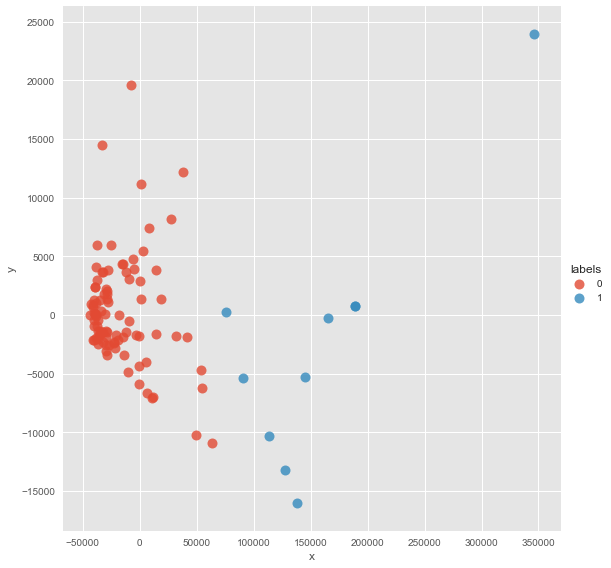

In [27]:
#visualize clusters using PCA method
import sklearn
kmeans = KMeans(n_clusters = 2)
kmeans.fit(x_cols)
labels = kmeans.labels_

#create data frame with only two components
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(kmeans_df1)
df_pca = pd.DataFrame(pca.transform(kmeans_df1))
df_pca.index = kmeans_df1.index
df_pca['labels'] = labels
df_pca.columns = ['x', 'y', 'labels']

#Plot scatter 
sns.lmplot(data=df_pca, x='x', y='y', hue='labels', size=8, fit_reg=False,scatter_kws={'s':100})

In [28]:
#Accuracy of model
(len(bloc_df)-sum(abs(bloc_df['Inefficient']-labels)))/len(bloc_df)

0.84466019417475724

#### Kmeans using energy parameters

In [29]:
#Create dataframe with dimension used to measure energy inefficiencies scaled by dividing building square footage
bloc_df['Square Feet'] = sf
d1 = bloc_df['Domestic Gas']/sf
d2 = bloc_df['Heating Gas']/sf
d3 = bloc_df['Plug Load Consumption']/sf
d4 = bloc_df['AC Consumption']/sf
columns = ['Domestic Gas', 'Heating Gas', 'Plug Load Consumption', 'AC Consumption']
kmeans_df2 = pd.DataFrame(columns=columns)
kmeans_df2['Domestic Gas'] = d1
kmeans_df2['Heating Gas'] = d2
kmeans_df2['Plug Load Consumption'] = d3
kmeans_df2['AC Consumption'] = d4

k = 2


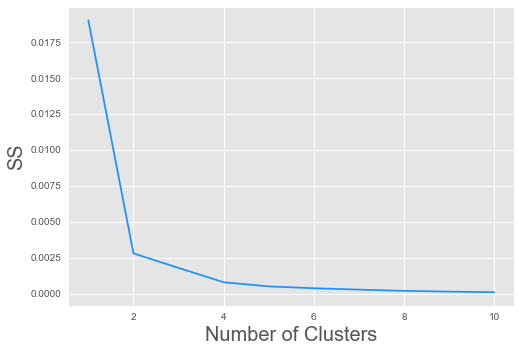

In [30]:
#Choosing K-clusters: elbow method
import scipy
from sklearn.cluster import KMeans

#Create numpy matrix x_cols
x_cols = kmeans_df2.as_matrix()

#Construct plot showing SS for each K
x =list(range(1,11))
y =[]
for k in range(1,11):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(x_cols)
    y.append(kmeans.inertia_)
plt.plot(x,y, color ='#1e90ff')
plt.ylabel("SS", fontsize=20)
plt.xlabel("Number of Clusters", fontsize=20)
print('k = 2')

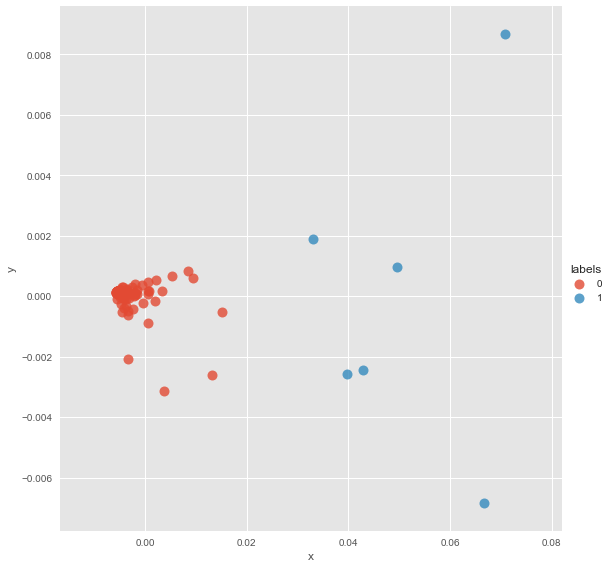

In [31]:
#visualize clusters using PCA method
import sklearn
kmeans = KMeans(n_clusters = 2)
kmeans.fit(x_cols)
labels = kmeans.labels_

#create data frame with only two components
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(kmeans_df2)
df_pca = pd.DataFrame(pca.transform(kmeans_df2))
df_pca.index = kmeans_df2.index
df_pca['labels'] = labels
df_pca.columns = ['x', 'y', 'labels']

#Plot scatter 
sns.lmplot(data=df_pca, x='x', y='y', hue='labels', size=8, fit_reg=False,scatter_kws={'s':100})

In [35]:
#Accuracy of model
1 - sum(abs(bloc_df['Inefficient']-labels))/len(bloc_df)

0.96116504854368934

# 7. Modelling: Supervised Learning

#### Random Forrest Classifier using all parameters

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_iris

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [37]:
# separate parameters and labels
df_x = bloc_df.iloc[:,1:11]
df_y = bloc_df.iloc[:,19]

In [38]:
#split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=.2, random_state=4)

In [39]:
#Run Random Forrest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [40]:
#Calculate predictions based testing data
predictions = rf.predict(x_test)

In [41]:
#Model Accuracy
count = 0
for i in range(len(predictions)):
    if predictions[i]==y_test.values[i]:
        count+=1
count/len(predictions)

1.0

Feature ranking:
1. feature 8 (0.349191)
2. feature 9 (0.255619)
3. feature 6 (0.098710)
4. feature 0 (0.062940)
5. feature 3 (0.058034)
6. feature 1 (0.048525)
7. feature 5 (0.038545)
8. feature 2 (0.034186)
9. feature 4 (0.030075)
10. feature 7 (0.024176)


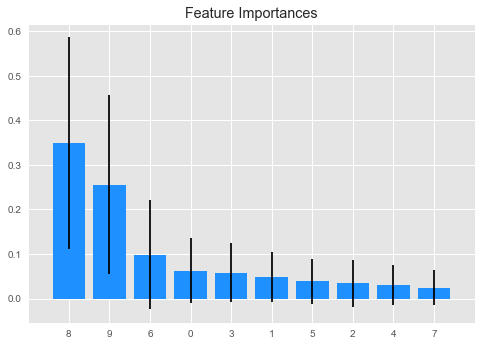

In [42]:
#Plot Feature Importances

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using informative features
X, y = x_train, y_train

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="#1e90ff", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [43]:
x_train.head(1)

,Energy Usage,Age,Number of Stories,Square Feet,PLEI_1,PLEI_3,Domestic Gas,Heating Gas,Plug Load Consumption,AC Consumption
86,54860.0,87.0,2,800.0,1.0,0.0,2.767528,1.341849,56.222162,14.778739


# 8. Geographic Visualization

In [106]:
import os
import folium

print(folium.__version__)

0.3.0


In [107]:
#Create list of coordinates for all buildings
df = bloc_df[['Latitude', 'Longitude', 'Inefficient']]
df = df[['Latitude', 'Longitude']]
locations = []
for i in df.values:
    locations.append((i[0],i[1]))

#Create list of coordinates for inefficient buildings    
inefficient_df = bloc_df[['Latitude', 'Longitude', 'Inefficient']]
inefficient_df = inefficient_df[inefficient_df['Inefficient']==True]
inefficient_df = inefficient_df[['Latitude', 'Longitude']]
locations_in = []
for i in inefficient_df.values:
    locations_in.append((i[0],i[1]))

In [108]:
#Map all buildings
from folium.plugins import MarkerCluster

m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()],
                  tiles='Cartodb Positron', zoom_start=10.3)
popups = ['{}'.format(loc) for loc in locations]
m.add_child(MarkerCluster(locations=locations, popups=popups,))

m

In [109]:
#Map inefficient buildings
from folium.plugins import MarkerCluster

m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()],
                  tiles='Cartodb Positron', zoom_start=10.3)
popups = ['{}'.format(loc) for loc in locations_in]
m.add_child(MarkerCluster(locations=locations_in, popups=popups,))

m

# 9 Environmental Performance

Greenhouse gas emmisison will be used as an environmetal performance metric. Since energy usage is in kWh a, conversion is required. Weill use EPA's Emission Factor 7.03 × 10-4 metric tons CO2 / kWh to convert to GHG emissions.

In [100]:
bloc_df['GHG Emission (mt)'] = bloc_df['Energy Usage']*.000703
bloc_df[['GHG Emission (mt)', 'Inefficient']].sort_values('GHG Emission (mt)', ascending=False).head(10)

,GHG Emission (mt),Inefficient
8,267.421200,False
6,160.976455,False
7,160.976455,False
70,144.351208,False
99,130.970306,False
54,127.130520,True
58,119.678720,True
51,109.724240,False
34,93.456820,False
0,82.862610,False


Based on GHG emissions only, is not enough to show environmental performance. Let's use a benchmark.

In [49]:
#Import Municipal Energy Benchmark from https://data.cityofnewyork.us
benchmark = pd.read_csv('NYC_Municipal_Building_Energy_Benchmarking_Results__2014_.csv')
benchmark.head(1)

,Borough,Block,Lot,BIN,Building,Agency,2010 Score *,2010Source EUI (kBtu/ft²)*,2010 GHG Emissions Intensity (kgCO2e/ft²)*,2014 Score *,2014 Source EUI (kBtu/ft²)*,2014 GHG Emissions Intensity (kgCO2e/ft²)*
0,1,93.0,1.0,1001280.0,ACS Administrative Site (Leased),ACS,57,239,6.2,76,219.5,5.8


In [50]:
#Data cleanup for benchmark
intensity = []
for i in benchmark['2014 GHG Emissions Intensity (kgCO2e/ft²)*']:
    try:
        intensity.append(np.float(i))
    except:
        intensity.append(np.nan)
benchmark['2014 GHG Emissions Intensity (kgCO2e/ft²)*'] = intensity
bench_value = (benchmark['2014 GHG Emissions Intensity (kgCO2e/ft²)*']/1000).mean()
bench_value

0.007687353535353535

In [51]:
bloc_df['Emissions Intensity'] = bloc_df['GHG Emission (mt)']/bloc_df['Square Feet']
len(bloc_df[bloc_df['Emissions Intensity']>bench_value][['Emissions Intensity','Inefficient']])

23

In [101]:
#List buildings that are perfoming badly regarding emisisons
bloc_df[bloc_df['Emissions Intensity']>bench_value][['Property Name' ,'Emissions Intensity','Inefficient']].sort_values('Emissions Intensity', ascending=False)

,Property Name,Emissions Intensity,Inefficient
86,PaninicoCafeReport,0.048208,True
101,LunaNYCafeCorpReport,0.044468,True
84,CAAABagels,0.043554,True
87,Curran'sSuperiorMeatsReport,0.039017,True
98,NewTestamentChristianChurch,0.034172,True
5,MoonbluIncdbaJoyBurgerBar,0.034172,True
54,AnchorHouse-ParkPl,0.027910,True
80,NYSERDA_Energy_Assessment_-_1011_Tavern_Corp_-...,0.026384,True
1,69thLaneStudio,0.018989,True
58,AnchorHouse-BergenSt,0.018985,True


Why does it matter? "74% of citywide greenhouse gas emissions come from the energy used in its buildings. And of that, more than half comes from energy used in just 2% of the largest properties.Those 2% are required to benchmark and disclose their energy use in accordance with a city law." https://www.nrdc.org/experts/melissa-wright/nyc-releases-1st-year-year-building-energy-performance-data-becomes-1st-us

We'll look at this buildings from 2012-2016

# 10. NYC's Greener Greater Buildings Plan

US: Local Law 84 of 2009 requiring buildings to disclose energy and water consumption.

In [53]:
#import data
df_2012 = pd.read_excel(open('2012_nyc_cy2011_ll84_disclosure_data.xlsx','rb'), sheetname='Energy and Water Data Disclosu')
df_2013 = pd.read_excel(open('2013_nyc_ll84_disclosure.xlsx','rb'), sheetname='2012 NYC Benchmark Data')
df_2014 = pd.read_excel(open('150428_2014_nyc_ll84_disclosure.xlsx','rb'), sheetname='2013 NYC Benchmark Data')
df_2015 = pd.read_excel(open('2015_nyc_cy2014__ll84_disclosure_data.xlsx','rb'), sheetname='WORKING FILE')
df_2016 = pd.read_excel(open('nyc_benchmarking_disclosure_data_reported_in_2016.xlsx','rb'), sheetname='2015 Data Reported in 2016')

In [54]:
#remove duplicates
df_2012 =df_2012.drop_duplicates(subset=['BBL'], keep='first')
df_2013 =df_2013.drop_duplicates(subset=['BBL'], keep='first')
df_2014 =df_2014.drop_duplicates(subset=['NYC Borough, Block, and Lot (BBL)'], keep='first')
df_2015 =df_2015.drop_duplicates(subset=['NYC Borough, Block, and Lot (BBL)'], keep='first')
df_2016 =df_2016.drop_duplicates(subset=['NYC Borough, Block and Lot (BBL)'], keep='first')

In [55]:
#bring together
buildings = df_2012[['BBL','Street Number', 'Street Name','Borough', 'Zip', 'Site EUI']]
buildings.columns =['BBL','Street Number', 'Street Name','Borough', 'Zip', 'Site EUI 2012']
buildings = pd.merge(buildings, df_2013, on='BBL')
buildings = buildings[['BBL', 'Street Number_x', 'Street Name_x', 'Borough_x', 'Zip_x','Site EUI 2012','Site EUI\n(kBtu/ft2)']]
buildings.columns =['BBL','Street Number', 'Street Name','Borough', 'Zip', 'Site EUI 2012', 'Site EUI 2013']
df_2014.rename(columns={'NYC Borough, Block, and Lot (BBL)': 'BBL'}, inplace=True)
buildings = pd.merge(buildings, df_2014, on='BBL')
buildings = buildings[['BBL', 'Street Number_x', 'Street Name_x', 'Borough_x', 'Zip',
                       'Site EUI 2012','Site EUI 2013', 'Site EUI\n(kBtu/ft2)']]
buildings.columns =['BBL','Street Number', 'Street Name','Borough', 'Zip', 'Site EUI 2012', 'Site EUI 2013', 'Site EUI 2014']
df_2015.rename(columns={'NYC Borough, Block, and Lot (BBL)': 'BBL'}, inplace=True)
buildings = pd.merge(buildings, df_2015, on='BBL')
buildings = buildings[['BBL', 'Street Number_x', 'Street Name_x', 'Borough_x', 'Zip',
                       'Site EUI 2012','Site EUI 2013', 'Site EUI 2014', 'Site EUI\n(kBtu/ft2)']]
buildings.columns =['BBL','Street Number', 'Street Name','Borough', 'Zip', 
                    'Site EUI 2012', 'Site EUI 2013', 'Site EUI 2014','Site EUI 2015']
df_2016.rename(columns={'NYC Borough, Block and Lot (BBL)': 'BBL'}, inplace=True)
buildings = pd.merge(buildings, df_2016, on='BBL')
buildings = buildings[['BBL', 'Street Number_x', 'Street Name_x', 'Borough_x', 'Zip',
                       'Site EUI 2012','Site EUI 2013', 'Site EUI 2014', 'Site EUI 2015', 
                       'Site EUI (kBtu/ft²)', 'DOF Property Floor Area (ft²)']]
buildings.columns =['BBL','Street Number', 'Street Name','Borough', 'Zip', 
                    'Site EUI 2012', 'Site EUI 2013', 'Site EUI 2014','Site EUI 2015', 'Site EUI 2016', 'sq ft.']
buildings.head(3)
buildings["Address"] = buildings['Street Number'].astype(str) + ' ' +buildings['Street Name'] + ' ' + buildings['Borough']
buildings.head()

,BBL,Street Number,Street Name,Borough,Zip,Site EUI 2012,Site EUI 2013,Site EUI 2014,Site EUI 2015,Site EUI 2016,sq ft.,Address
0,1000090001,34,WHITEHALL STREET,MANHATTAN,10004,157.9,99.5,78.5,81.3,71.4,845018.0,34 WHITEHALL STREET MANHATTAN
1,1000090014,17,STATE STREET,MANHATTAN,10004,91.5,79.7,68.6,80.8,77.2,544015.0,17 STATE STREET MANHATTAN
2,1000090029,24,WHITEHALL STREET,MANHATTAN,10004,137.2,139.4,148.4,136.2,118.6,896956.0,24 WHITEHALL STREET MANHATTAN
3,1000100016,90,BROAD STREET,MANHATTAN,10004,53.5,39.8,NaN,25896.9,17938.1,336025.0,90 BROAD STREET MANHATTAN
4,1000100023,1,WHITEHALL STREET,MANHATTAN,10004,113.1,102.8,108,106.8,102.2,321994.0,1 WHITEHALL STREET MANHATTAN


In [56]:
buildings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2761 entries, 0 to 2760
Data columns (total 12 columns):
BBL              2761 non-null object
Street Number    2755 non-null object
Street Name      2761 non-null object
Borough          2761 non-null object
Zip              2761 non-null int64
Site EUI 2012    1672 non-null float64
Site EUI 2013    1988 non-null float64
Site EUI 2014    1889 non-null object
Site EUI 2015    2198 non-null object
Site EUI 2016    2332 non-null float64
sq ft.           2756 non-null float64
Address          2761 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 280.4+ KB


In [57]:
#convert object types to floats
eui_2014 = []
for i in buildings['Site EUI 2014']:
    try:
        eui_2014.append(np.float(i))
    except:
        eui_2014.append(np.nan)
buildings['Site EUI 2014'] = eui_2014

eui_2015 = []
for i in buildings['Site EUI 2015']:
    try:
        eui_2015.append(np.float(i))
    except:
        eui_2015.append(np.nan) 
buildings['Site EUI 2015'] = eui_2015

In [58]:
#fill missiong values with means
means =[]
for i in buildings.values:
    mean = [i[5], i[6], i[7], i[8], i[9]]
    means.append(np.nanmean(mean))
  
columns = ['BBL', 'Street Number', 'Street Name', 'Borough', 'Zip', 'Site EUI 2012', 'Site EUI 2013', 'Site EUI 2014',
           'Site EUI 2015', 'Site EUI 2016', 'sq ft.']
for i in range(len(buildings)):
    for x in range(5,10):
        if np.isnan(buildings.iloc[i,x]):
            buildings.set_value(i, columns[x], means[i])
buildings.head(5)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


,BBL,Street Number,Street Name,Borough,Zip,Site EUI 2012,Site EUI 2013,Site EUI 2014,Site EUI 2015,Site EUI 2016,sq ft.,Address
0,1000090001,34,WHITEHALL STREET,MANHATTAN,10004,157.9,99.5,78.500,81.3,71.4,845018.0,34 WHITEHALL STREET MANHATTAN
1,1000090014,17,STATE STREET,MANHATTAN,10004,91.5,79.7,68.600,80.8,77.2,544015.0,17 STATE STREET MANHATTAN
2,1000090029,24,WHITEHALL STREET,MANHATTAN,10004,137.2,139.4,148.400,136.2,118.6,896956.0,24 WHITEHALL STREET MANHATTAN
3,1000100016,90,BROAD STREET,MANHATTAN,10004,53.5,39.8,10982.075,25896.9,17938.1,336025.0,90 BROAD STREET MANHATTAN
4,1000100023,1,WHITEHALL STREET,MANHATTAN,10004,113.1,102.8,108.000,106.8,102.2,321994.0,1 WHITEHALL STREET MANHATTAN


In [59]:
#Removing Inconsistent Values
list_2012 = list(buildings[buildings['Site EUI 2012']>1000]['BBL'])
list_2013 = list(buildings[buildings['Site EUI 2013']>1000]['BBL'])
list_2014 = list(buildings[buildings['Site EUI 2014']>1000]['BBL'])
list_2015 = list(buildings[buildings['Site EUI 2015']>1000]['BBL'])
list_2016 = list(buildings[buildings['Site EUI 2016']>1000]['BBL'])

agg = list_2012 + list_2013 + list_2014 + list_2015 + list_2016
removal =[]
for i in agg:
    if i in removal:
        pass
    else: 
        removal.append(i)

In [60]:
#Analyze outliers to choose inconsistent ones
buildings[buildings['BBL'].isin(removal)].iloc[60:,:]
 
removal = [3, 39, 46, 62, 128, 129, 142, 174, 305, 307, 311, 508, 509, 525, 543, 606, 672, 676, 709, 773, 796, 837, 845, 850, 881, 888,
916, 919, 931, 969, 1021, 1053, 1071, 1085, 1115, 1116, 1161, 1178, 1179, 1206, 1274, 1284, 1334, 1340, 1373, 1382, 1452, 1888, 1900, 2339,
2432, 2535, 2608, 2656, 2681]

buildings = buildings.drop(removal)

In [61]:
#calculate Energy Use Intensity
x = [2012, 2013, 2014, 2015, 2016]
y = [buildings['Site EUI 2012'].mean(), buildings['Site EUI 2013'].mean(), buildings['Site EUI 2014'].mean(),
    buildings['Site EUI 2015'].mean(), buildings['Site EUI 2016'].mean()]

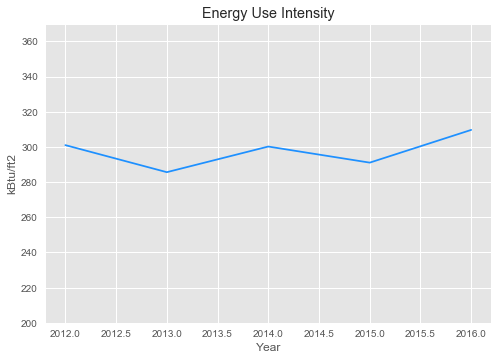

In [62]:
#Plot EUIs
plt.plot(x,y, color='#1e90ff')
plt.ylim(200,370)
plt.title('Energy Use Intensity')
plt.ylabel('kBtu/ft2')
plt.xlabel('Year')

In [63]:
# Add coordinates from http://www.freegeocoding.com
coordinates = pd.read_excel(open('building coordinates.xlsx','rb'), sheetname='Sheet1')
buildings = pd.merge(buildings, coordinates, on='Address')
buildings.head(3)

,BBL,Street Number,Street Name,Borough,Zip,Site EUI 2012,Site EUI 2013,Site EUI 2014,Site EUI 2015,Site EUI 2016,sq ft.,Address,Lon,Lat
0,1000090001,34,WHITEHALL STREET,MANHATTAN,10004,157.9,99.5,78.5,81.3,71.4,845018.0,34 WHITEHALL STREET MANHATTAN,-73.989353,40.729733
1,1000090014,17,STATE STREET,MANHATTAN,10004,91.5,79.7,68.6,80.8,77.2,544015.0,17 STATE STREET MANHATTAN,-74.012345,40.714512
2,1000090029,24,WHITEHALL STREET,MANHATTAN,10004,137.2,139.4,148.4,136.2,118.6,896956.0,24 WHITEHALL STREET MANHATTAN,-73.992312,40.722156


In [291]:
df_1 = buildings
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('pandas_simple.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df_1.to_excel(writer, sheet_name='Sheet2')

# Close the Pandas Excel writer and output the Excel file.
writer.save()   

In [64]:
#Assign locations to clusters

lon_a = -73
lon_b = -73.9103205
lon_c = -73.9624929
lon_d = -73.98222
lon_e = -73.9920453
lon_f = -74.243756


lat_a = 40
lat_b = 40.70452
lat_c = 40.7416969
lat_d = 40.754149
lat_e = 40.7626903
lat_f = 40.9124186

In [65]:
df = buildings[['BBL', 'Address', 'Lon', 'Lat', 'Site EUI 2012', 'Site EUI 2013',
                'Site EUI 2014', 'Site EUI 2015', 'Site EUI 2016']]
clusters = []
wrong = []
for i in df.values:
    if lon_b<=i[2]<=lon_a and lat_a<=i[3]<lat_b:
        clusters.append(1)    
    elif lon_c<=i[2]<lon_b and lat_a<=i[3]<lat_b:
        clusters.append(2)   
    elif lon_c<=i[2]<lon_b and lat_b<=i[3]<lat_c:
        clusters.append(3)
    elif lon_b<=i[2]<=lon_a and lat_b<=i[3]<lat_c:
        clusters.append(4)    
    elif lon_d<=i[2]<lon_c and lat_a<=i[3]<lat_b:
        clusters.append(5)  
    elif lon_d<=i[2]<lon_c and lat_b<=i[3]<lat_c:
        clusters.append(6)    
    elif lon_d<=i[2]<lon_c and lat_c<=i[3]<lat_d:
        clusters.append(7)    
    elif lon_c<=i[2]<lon_b and lat_c<=i[3]<lat_d:
        clusters.append(8)    
    elif lon_b<=i[2]<=lon_a and lat_c<=i[3]<lat_d:
        clusters.append(9)    
    elif lon_e<=i[2]<lon_d and lat_a<=i[3]<lat_b:
        clusters.append(10)    
    elif lon_e<=i[2]<lon_d and lat_b<=i[3]<lat_c:
        clusters.append(11)   
    elif lon_e<=i[2]<lon_d and lat_c<=i[3]<lat_d:
        clusters.append(12)  
    elif lon_e<=i[2]<lon_d and lat_d<=i[3]<lat_e:
        clusters.append(13)   
    elif lon_d<=i[2]<lon_c and lat_d<=i[3]<lat_e:
        clusters.append(14) 
    elif lon_c<=i[2]<lon_b and lat_d<=i[3]<lat_e:
        clusters.append(15) 
    elif lon_b<=i[2]<=lon_a and lat_d<=i[3]<lat_e:
        clusters.append(16) 
    elif lon_f<=i[2]<lon_e and lat_a<=i[3]<=lat_b:
        clusters.append(17)   
    elif lon_f<=i[2]<lon_e and lat_b<=i[3]<lat_c:
        clusters.append(18)  
    elif lon_f<=i[2]<lon_e and lat_c<=i[3]<lat_d:
        clusters.append(19)
    elif lon_f<=i[2]<lon_e and lat_d<=i[3]<lat_e:
        clusters.append(20)  
    elif lon_f<=i[2]<lon_e and lat_e<=i[3]<=lat_f:
        clusters.append(21)
    elif lon_e<=i[2]<lon_d and lat_e<=i[3]<=lat_f:
        clusters.append(22)
    elif lon_d<=i[2]<lon_c and lat_e<=i[3]<=lat_f:
        clusters.append(23)
    elif lon_c<=i[2]<lon_b and lat_e<=i[3]<=lat_f:
        clusters.append(24)
    elif lon_b<=i[2]<=lon_a and lat_e<=i[3]<=lat_f:
        clusters.append(25) 
    else: wrong.append(i)
df['clusters'] = clusters
df.head(1)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,BBL,Address,Lon,Lat,Site EUI 2012,Site EUI 2013,Site EUI 2014,Site EUI 2015,Site EUI 2016,clusters
0,1000090001,34 WHITEHALL STREET MANHATTAN,-73.989353,40.729733,157.9,99.5,78.5,81.3,71.4,11


In [68]:
#Map Buildings EUI 2012
from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure

df1 =df.groupby('clusters').sum()
values = list(df1['Site EUI 2012'])
clusts = list(df1.index)
color_mapper = LogColorMapper(palette=palette)

lons =[]
for x in clusts:
    l =[]
    for i in df.values:
        if i[9]==x:
            l.append(i[2])
    lons.append(l)
lats =[]
for x in clusts:
    l =[]
    for i in df.values:
        if i[9]==x:
            l.append(i[3])
    lats.append(l)

source = ColumnDataSource(data=dict(
    x=lons,
    y=lats,
    name=clusts,
    rate=values,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="New York EUI 2012", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Cluster", "@name"),
    ("EUI)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]

show(p)

C:\Users\USER\Anaconda3\lib\site-packages\bokeh\core\json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


In [73]:
#Map Buildings EUI 2013
from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure

df1 =df.groupby('clusters').sum()
values = list(df1['Site EUI 2013'])
clusts = list(df1.index)
color_mapper = LogColorMapper(palette=palette)

lons =[]
for x in clusts:
    l =[]
    for i in df.values:
        if i[9]==x:
            l.append(i[2])
    lons.append(l)
lats =[]
for x in clusts:
    l =[]
    for i in df.values:
        if i[9]==x:
            l.append(i[3])
    lats.append(l)

source = ColumnDataSource(data=dict(
    x=lons,
    y=lats,
    name=clusts,
    rate=values,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="New York EUI 2013", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Cluster", "@name"),
    ("EUI)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]

show(p)

In [75]:
#Map Buildings EUI 2014
from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure

df1 =df.groupby('clusters').sum()
values = list(df1['Site EUI 2014'])
clusts = list(df1.index)
color_mapper = LogColorMapper(palette=palette)

lons =[]
for x in clusts:
    l =[]
    for i in df.values:
        if i[9]==x:
            l.append(i[2])
    lons.append(l)
lats =[]
for x in clusts:
    l =[]
    for i in df.values:
        if i[9]==x:
            l.append(i[3])
    lats.append(l)

source = ColumnDataSource(data=dict(
    x=lons,
    y=lats,
    name=clusts,
    rate=values,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="New York EUI 2014", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Cluster", "@name"),
    ("EUI)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]

show(p)

In [77]:
#Map Buildings EUI 2015
from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure

df1 =df.groupby('clusters').sum()
values = list(df1['Site EUI 2015'])
clusts = list(df1.index)
color_mapper = LogColorMapper(palette=palette)

lons =[]
for x in clusts:
    l =[]
    for i in df.values:
        if i[9]==x:
            l.append(i[2])
    lons.append(l)
lats =[]
for x in clusts:
    l =[]
    for i in df.values:
        if i[9]==x:
            l.append(i[3])
    lats.append(l)

source = ColumnDataSource(data=dict(
    x=lons,
    y=lats,
    name=clusts,
    rate=values,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="New York EUI 2015", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Cluster", "@name"),
    ("EUI)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]

show(p)

In [78]:
#Map Buildings EUI 2016
from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure

df1 =df.groupby('clusters').sum()
values = list(df1['Site EUI 2016'])
clusts = list(df1.index)
color_mapper = LogColorMapper(palette=palette)

lons =[]
for x in clusts:
    l =[]
    for i in df.values:
        if i[9]==x:
            l.append(i[2])
    lons.append(l)
lats =[]
for x in clusts:
    l =[]
    for i in df.values:
        if i[9]==x:
            l.append(i[3])
    lats.append(l)

source = ColumnDataSource(data=dict(
    x=lons,
    y=lats,
    name=clusts,
    rate=values,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="New York EUI 2016", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Cluster", "@name"),
    ("EUI)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]

show(p)